In [304]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray
#import GOESpolling

from metpy.plots import colortables
from datetime import datetime
from metpy.plots import USCOUNTIES

## Define Directories and Settings

In [305]:
# Directories
dataDir = '/home/CarterHumphreys/bin/data/GOES/'
plotDir = '/home/CarterHumphreys/bin/send2web/'

In [306]:
# Settings
figX=20
figY=10
dpi=100
domain=[-98.5, -83.5, 27.0, 39.0]
showCountryBorders=True
showStateBorders=True
showCountyBorders=True
exportPlt=True

## Open NetCDF File

In [307]:
# Load data
#latestScan = GOESpolling.getLatestScan('goes16', 'ABI-L2-MCMIP', 'CONUS', 2, True, dataDir)
goesFile = xarray.open_dataset(dataDir + 'OR_ABI-L2-MCMIPM1-M6_G16_s20201032125216_e20201032125273_c20201032125351.nc')

## Scan Information

In [308]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(goesFile.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(goesFile.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(goesFile.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
midpoint = str(goesFile['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : {}'.format(scan_start))
print('Scan midpoint : {}'.format(scan_mid))
print('Scan End      : {}'.format(scan_end))
print('File Created  : {}'.format(file_created))
print('Scan Duration : {:.2f} minutes'.format((scan_end-scan_start).seconds/60))

Scan Start    : 2020-04-12 21:25:21.600000
Scan midpoint : 2020-04-12 21:25:24.400000
Scan End      : 2020-04-12 21:25:27.300000
File Created  : 2020-04-12 21:25:35.100000
Scan Duration : 0.08 minutes


## Plot Bands

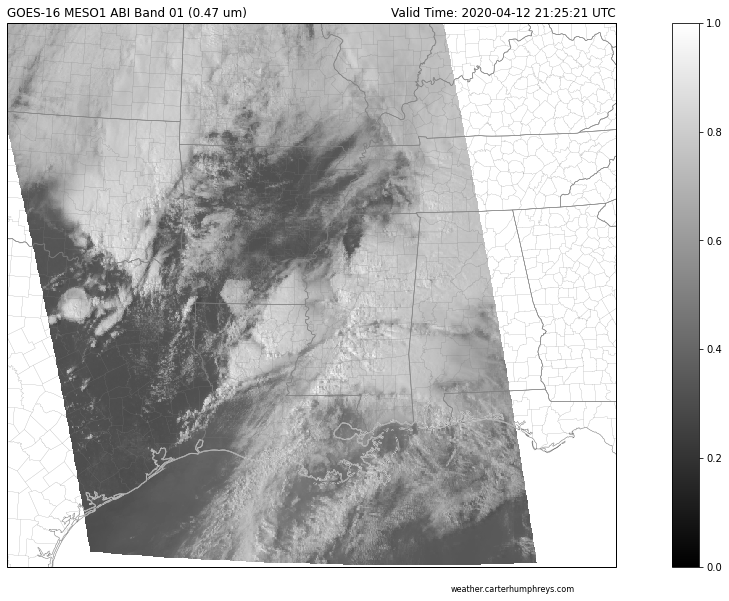

Saving export/GOES16_ABI-L2-MCMIP_M1_BAND01_20200412_212521.png


In [ ]:
# Confirm that each band is the wavelength we are interested in
for band in range(16):
    bandNumber=band+1
    bandName=goesFile['band_wavelength_C{:02d}'.format(bandNumber)].long_name
    bandWavelength=float(goesFile['band_wavelength_C{:02d}'.format(bandNumber)][0])
    bandWavelength="{:.2f}".format(bandWavelength)
    bandUnits=goesFile['band_wavelength_C{:02d}'.format(bandNumber)].units
    
    # Load band data
    data=goesFile[f'CMI_C{str(bandNumber).zfill(2)}'].data
    
    # Apply range limits for channel. RGB values must be between 0 and 1
    data=np.clip(data, 0, 1)
    
    # Apply a gamma correction to the image to correct ABI detector brightness
    gamma = 2.2
    data = np.power(data, 1/gamma)
    
    # Get the CF metadata from CMI_C02 variable
    dat = goesFile.metpy.parse_cf(f'CMI_C{str(bandNumber).zfill(2)}')
    scan_start = datetime.strptime(goesFile.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

    # Get x (north/south) and y (east/west) axis sweep of the ABI data
    x, y = dat.x, dat.y

    # Define plot
    fig = plt.figure(figsize=(figX, figY))
    geos = dat.metpy.cartopy_crs
    
    # Color Map
    cmap='gray'
    if bandNumber==7 or bandNumber==13 or bandNumber==14 or bandNumber==15:
        cmap=colortables.get_colortable('ir_rgbv')
    elif bandNumber==8 or bandNumber==9 or bandNumber==10:
        cmap=colortables.get_colortable('WVCIMSS')

    # Generate an Cartopy projection
    proj = ccrs.Stereographic(central_longitude=((domain[1]-domain[0])/2+domain[0]), central_latitude=((domain[3]-domain[2])/2+domain[2]))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_extent(domain)
    plt.imshow(data, cmap=cmap, vmin=0, vmax=1, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
    plt.colorbar()
    
    # Add geographic features
    if showCountryBorders:
        country_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='10m', facecolor='none')
        ax.add_feature(country_borders, edgecolor='white', linewidth=1.0)

    if showStateBorders:
        state_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='10m', facecolor='none')
        ax.add_feature(state_borders, edgecolor='gray', linewidth=0.5)

    if showCountyBorders:
        ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='gray', linewidth=0.1)

    #Plot Headers
    plt.title(f'GOES-16 MESO1 ABI Band {str(bandNumber).zfill(2)} ({bandWavelength} {bandUnits})', loc='left')
    plt.title(f'Valid Time: {scan_start.strftime("%Y-%m-%d %H:%M:%S UTC")}', loc='right')
    
    # Add citation
    fig.text(0.63, 0.09, 'weather.carterhumphreys.com', fontsize=8)

    # Export fig and close
    plt.show()
    
    # Export
    if exportPlt:
        fileName=f'export/GOES16_ABI-L2-MCMIP_M1_BAND{str(bandNumber).zfill(2)}_{scan_start.strftime("%Y%m%d_%H%M%S")}.png'
        print(f'Saving {fileName}')
        fig.savefig(fileName, bbox_inches='tight')